In [4]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from o2delta_model import gA
array_like_types = (list, tuple, np.ndarray, xr.core.dataarray.DataArray)
numeric_types = (int, float)
NoneType = (type(None),)
s2h = 1/3600
h2s = 3600

In [5]:
# def func_sza(t=np.linspace(0, 3600*24), elv_max=90):
#     #t in s
#     elv = elv_max - 90*((np.cos(2*np.pi/(3600*24) * t)) + 1)
#     if isinstance(t, numeric_types):
#         if elv>89.9:
#             elv=89.9
#         elif elv<0.1:
#             elv=0.1
#     elif isinstance(t, array_like_types):
#         elv[elv>89.9] = 89.9
#         elv[elv<0.1] = 0.1
#     return 90-elv

def func_sza(t=np.linspace(0, 3600*24), elv_max=90):
    #t in s
    elv = elv_max - 90*((np.cos(2*np.pi/(3600*24) * t)) + 1)
    return 90-elv

# J and g functions

In [6]:
ds_xs = xr.open_dataset('./xs_anqi.nc')
wavelength = ds_xs.wavelength.values
so2 = ds_xs.so2.values
so3 = ds_xs.so3.values
irrad = ds_xs.irrad.values

In [9]:
# from numba import jit
# @jit(nopython = True, cache = True)
def path_z (z_top, z_t, sol_zen, nsteps):
    if sol_zen == 0:
        z_step = np.linspace(z_top, z_t, nsteps)
        step = (z_top - z_t)/nsteps
    elif sol_zen == 180:
        z_step = np.zeros(nsteps)
        step = 0
    else:     
        Re = 6375 #km (should be the same unit as z)
        sol_zen /= 180/np.pi
        B=np.arcsin((Re+z_t) * np.sin(np.pi-sol_zen)/(Re+z_top))
        S_top=np.sin(sol_zen-B)*(Re+z_top)/np.sin(np.pi-sol_zen)

        Ret2=(Re + z_t)**2
        step=S_top/nsteps
        S_top_half= S_top - step/2
        z_step=[np.sqrt(Ret2 +(S_top_half - i*step)**2 -
                        2*(Re + z_t)*(S_top_half - 
                          i*step)*np.cos(np.pi-sol_zen))-Re for i in range(nsteps) ]
        z_step = np.array(z_step)
    #check the Earth's shadow
    if (z_step<0).any():
        z_step = np.zeros(nsteps)    
    return(z_step, step)

def photolysis(z, sol_zen, density_lst, xs_lst, name_lst):
    #z in km
    #density in cm-3
    #xs (cross section) in cm2
    #global variables: z, wavelength, irrad
    j_lst = [[] for i in range(len(density_lst))]
    j_sum_lst = [[] for i in range(len(density_lst))]
    for iz, z_t in enumerate(z) :
        z_paths, path_step= path_z(z[-1],z_t,sol_zen,100)
        attenuation_coeff = [xs * (np.exp(np.interp(z_paths, z, np.log(density)))).sum()  #sum over z_paths
                               for xs, density in zip(xs_lst, density_lst)]
        tau = np.sum(attenuation_coeff, axis=0) * path_step *1e5 #km-->cm , sum over species   
        j_z_lst = (irrad * xs_lst * np.exp(-tau)) #
        [j.append(j_z) for j,j_z in zip(j_lst, j_z_lst)]
        [j_sum.append(j_z.sum()) for j_sum,j_z in zip(j_sum_lst, j_z_lst)] #sum over wavelength
    
    data_j = {'j{}'.format(name): (('z', 'wavelength'), j) for name,j in zip(name_lst, j_lst)}
    data_j_sum = {'j{}_sum'.format(name): (('z',), j_sum) for name,j_sum in zip(name_lst, j_sum_lst)}

    return xr.Dataset({'z': (('z',), z),
                       'wavelength': (('wavelength',), wavelength),
                       **data_j, **data_j_sum})

# test2 = photolysis(z=z, sol_zen=95, density_lst=(o2.density, o3.density), xs_lst=(so2, so3), name_lst=('o2', 'o3'))
# test2.jo3.sel(wavelength=slice(210,310)).sum('wavelength').plot.line(y='z')
# test2 = photolysis(z=z, sol_zen=90, density_lst=(o2.density, o3.density), xs_lst=(so2, so3), name_lst=('o2', 'o3'))
# test2.jo3.sel(wavelength=slice(210,310)).sum('wavelength').plot.line(y='z')
# plt.show()

# Classes

In [10]:
class RateConstant:
    def __init__(self, value=None, unit=None, ref=None, name=None, reaction_name=None):
        self.value = value
        self.unit = unit
        self.ref = ref
        self.name = name
        self.reaction_name = reaction_name

    def set_value(self, value):
        self.value = value
        return self
    def set_unit(self, unit):
        self.unit = unit
        return self
    def set_ref(self, ref):
        self.ref = ref
    def set_name(self, name):
        self.name = name
        return self
    def set_reaction_name(self, reaction_name):
        self.reaction_name = reaction_name
        return self
    def remove_value(self):
        self.value = None

class Species:
    def __init__(self, density=None, unit=None, name=None):
        self.density = density
        self.unit = unit
        self.name = name

    def set_density(self, density):
        self.density = density
        return self
    def set_unit(self, unit):
        self.unit = unit
        return self
    def set_name(self, name):
        self.name = name
        return self
    def remove_density(self):
        self.density = None
            

class Reaction: #general reactions
    reaction_type = 'genral reaction'
    
    def __init__(self,  
                 rate_constant=RateConstant(), 
                 reactants=(), 
                 products=(),  
                 name=None):
        self.rate_constant = rate_constant
        self.reactants = reactants
        self.products = products
        self.name = name

    def set_rate_constant(self, rate_constant):
        self.rate_constant = rate_constant
        return self
    def set_reactants(self, reactants):
        self.reactants = reactants
        return self
    def set_products(self, products):
        self.products = products
        return self
    def set_name(self, name):
        self.name = name
        return self
    
    def rate(self):        
        rate = self.rate_constant.value * np.prod([s.density for s in self.reactants], axis=0)
        return rate
        
    def show(self):
        reactant_names = [x.name for x in self.reactants]
        product_names = [x.name for x in self.products]
        print(self.name, reactant_names, self.rate_constant.name, product_names)

    def show_reactant_names(self):
        print([x.name for x in self.reactants])   

### a function to calculate the lifetime of a species in query

In [11]:
def lifetime(species_query, reaction_lst):
    #species_query is an instance of class Species
    #reaction_lst is a list of reactions
    #tau (total lifetime) is np array
    #loss_sources is a dictionary with reaction names as keys and losses (array) as values
    
    #find stoichiometric coefficients
    loss_stoichio_coeff = np.array([r.reactants.count(species_query) for r in reaction_lst])
    
    #calculate relavant losses 
    loss_sources = {}
    for r in reaction_lst:
        if loss_stoichio_coeff[reaction_lst.index(r)]==1:
            reactants_ex = [s for s in r.reactants if s!=species_query]
            L = r.rate_constant.value * np.prod([s.density for s in reactants_ex], axis=0)
            loss_sources[r.name] = L

        elif loss_stoichio_coeff[reaction_lst.index(r)]>1:
            ''' I dont know how to do higher order reaction yet '''
            pass
        else:
            pass
        
    #sum relavant losses
    loss_sum = np.zeros(z.shape)
    for L in loss_sources.values():
        loss_sum += L
    
    tau = 1/loss_sum
    return tau, loss_sources
    

In [12]:
def prod_rate(species_query, reaction_lst):
    #species_query is an instance of class Species
    #reaction_lst is a list of reactions
    #prod_sum is a np arry

    #find stoichiometric coefficients
    prod_stoichio_coeff = np.array([r.products.count(species_query) for r in reaction_lst])

    #calculate production rates
    prod_rates = [r.rate() * n
                  for r, n in zip(reaction_lst, prod_stoichio_coeff) if n>0]
        
    #sum up all the relavant production rates and losses
    prod_sum = np.zeros(z.shape)
    for P in prod_rates:
        prod_sum += P
    return prod_sum

def loss_rate(species_query, reaction_lst):
    #species_query is an instance of class Species
    #reaction_lst is a list of reactions
    #loss_sum is a np array

    #find stoichiometric coefficients
    loss_stoichio_coeff = np.array([r.reactants.count(species_query) for r in reaction_lst])

    #calculate loss rates
    loss_rates = [r.rate() * n
                  for r, n in zip(reaction_lst, loss_stoichio_coeff) if n>0]
        
    #sum up all the relavant production rates and losses
    loss_sum = np.zeros(z.shape)
    for P in loss_rates:
        loss_sum += P
    return loss_sum

### A function to calculate rate of change of a species in query

In [13]:
def continuity(species_query, reaction_lst):
    #species_query is an instance of class Species
    #reaction_lst is a list of reactions
    # dxdt, prod_sum, loss_sum are np.array
    
    prod_sum = prod_rate(species_query, reaction_lst)
    loss_sum = loss_rate(species_query, reaction_lst)
    #continuity equation
    dxdt = prod_sum - loss_sum
    
    return dxdt, prod_sum, loss_sum

### A function to calculate a query species density by assuming equilibrium


In [14]:
def equilibrium(species_query, reaction_lst):
    #species_query is an instance of class Species
    #reaction_lst is a list of reactions
    #density_query is a np array
        
    prod_sum = prod_rate(species_query, reaction_lst)
    loss_sum = 1/lifetime(species_query, reaction_lst)[0]
    
    density_query = prod_sum/loss_sum
    return density_query

# Set up species and a list of equations of the model

In [15]:
n2 = Species(name='N2')
o2 = Species(name='O2')
o3 = Species(name='O3')
o = Species(name='O')
o1d = Species(name='O(1D)')
o2sig = Species(name='O2(b sig)')
o2del = Species(name='O2(a del)')
m = Species(name='M')

species_lst = [n2, o2, o3, o, o1d, o2sig, o2del, m]

reaction_lst = [
    Reaction(reactants=(o3,), products=(o1d, o2del), name='Jo3'),
    Reaction(reactants=(o1d, o2), products=(o, o2sig), name='Q1d_o2'),
    Reaction(reactants=(o1d, n2), products=(o, n2), name='Q1d_n2'),
    Reaction(reactants=(o2sig, m), products=(o2del, m), name='Qsig_m'),
    Reaction(reactants=(o2del, o2), products=(o2, o2), name='Qdel_o2'),
    Reaction(reactants=(o2sig,), products=(o2,), name='Asig'),
    Reaction(reactants=(o2del,), products=(o2,), name='Adel'),
    Reaction(reactants=(o2,), products=(o2sig,), name='gA')]

reaction_lst[2].show()

Q1d_n2 ['O(1D)', 'N2'] None ['O', 'N2']


### Set some of the densities and rate constants

In [16]:
clima = xr.open_dataset('/home/anqil/Documents/Python/external_data/msis_cmam_climatology_z200_lat8576.nc')
z = clima.z.sel(z=slice(50,110,5)).values
sel_clima_args = dict(month=12, lat=0, z=z, method='nearest')
T = clima.sel(**sel_clima_args).T.values
o2 = o2.set_density(clima.sel(**sel_clima_args).o2.values*1e-6).set_unit('cm-3')
n2 = n2.set_density(clima.sel(**sel_clima_args).n2.values*1e-6).set_unit('cm-3')
o = o.set_density(clima.sel(**sel_clima_args).o.values*1e-6).set_unit('cm-3')
m = m.set_density(o2.density+n2.density).set_unit('cm-3')

In [17]:
rate_const_lst = [
    RateConstant(reaction_name='Jo3', unit='s-1'), 
    RateConstant(value=2.9e-11*np.exp(-67/T), reaction_name='Q1d_o2', unit='cm3s-1'), 
    RateConstant(value=1.0e-11*np.exp(-107/T), reaction_name='Q1d_n2', unit='cm3s-1'), 
    RateConstant(value=1.0e-15, reaction_name='Qsig_m', unit='cm3s-1'), 
    RateConstant(value=2.22e-18*np.exp(T/300)**0.78, reaction_name='Qdel_o2', unit='cm3s-1'), 
    RateConstant(value=0.085, reaction_name='Asig', unit='s-1'), 
    RateConstant(value=2.58e-4, reaction_name='Adel', unit='s-1'),
    RateConstant(reaction_name='gA', unit='s-1')]

#set available rate constant to each reaction
reaction_lst = [r.set_rate_constant(next(k for k in rate_const_lst if k.reaction_name==r.name)
                                   ) for r in reaction_lst]

### test on o2del in equilibrium (see if the functions above give error)

sza = 0.0
CPU times: user 42.5 ms, sys: 626 µs, total: 43.2 ms
Wall time: 41.9 ms


Text(0.5, 0, 'do2del_dt')

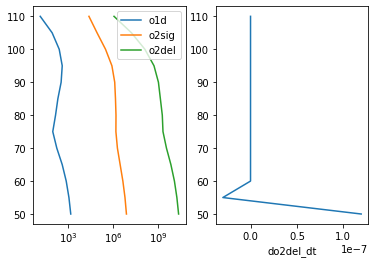

In [18]:
%%time
o3.remove_density()
o1d.remove_density()
o2sig.remove_density()
o2del.remove_density()

# test on o2delta and see if an error occurrs
lst = 12 #hour

#set o3 density and photolysis rates
o3 = o3.set_density(m.density*clima.o3_vmr.sel(**sel_clima_args, lst=lst).values).set_unit('cm-3')
sol_zen = func_sza(t=lst*h2s)
print('sza =',sol_zen)
ds_j = photolysis(z=z, sol_zen=sol_zen, density_lst=(o2.density, o3.density), xs_lst=(so2, so3), name_lst=('o2', 'o3'))
next(r for r in reaction_lst if r.name=='Jo3'
    ).rate_constant.set_value(ds_j.jo3.sel(wavelength=slice(210,310)).sum('wavelength').values)
if sol_zen<90:
    next(r for r in reaction_lst if r.name=='gA'
        ).rate_constant.set_value(gA(clima.p.sel(**sel_clima_args), sol_zen))
else:
    next(r for r in reaction_lst if r.name=='gA'
        ).rate_constant.set_value(np.zeros(z.shape))
    
#set equilibrium species densities
o1d = o1d.set_density(equilibrium(o1d, reaction_lst))
o2sig = o2sig.set_density(equilibrium(o2sig, reaction_lst))
o2del = o2del.set_density(equilibrium(o2del, reaction_lst))

#calculate query species density rate of change 
do2del_dt, *_ = continuity(o2del, reaction_lst)

plt.figure()
plt.subplot(121)
plt.semilogx(o1d.density, z, label='o1d')
plt.semilogx(o2sig.density, z, label='o2sig')
plt.semilogx(o2del.density, z, label='o2del')
plt.legend()

plt.subplot(122)
plt.plot(do2del_dt, z)
plt.xlabel('do2del_dt')

# Integration 

In [19]:
def time_dependent_variables(t_s, elv_max=90):
    o3_density = m.density*clima.o3_vmr.sel(**sel_clima_args).interp(lst=t_s*s2h).values#t_s*s2h).values
    sol_zen = func_sza(t=t_s, elv_max=elv_max) #t=t_s
    ds_j = photolysis(z=z, sol_zen=sol_zen, 
                      density_lst=(o2.density, o3_density), xs_lst=(so2, so3), name_lst=('o2', 'o3'))
    Jhart = ds_j.jo3.sel(wavelength=slice(210,310)).sum(dim='wavelength').values
    if sol_zen<90:
        g = gA(clima.p.sel(**sel_clima_args), sol_zen)
    else:
        g = np.zeros(z.shape)
    # set into the objects 
    o3.set_density(o3_density)
    next(r for r in reaction_lst if r.name=='Jo3').rate_constant.set_value(Jhart)
    next(r for r in reaction_lst if r.name=='gA').rate_constant.set_value(g)
    return o3_density, Jhart, g

In [20]:
def balance(species_query_density, t_s, species_query, reaction_lst, species_equilibrium, elv_max=89.9):
    #t_s in second
    #species_query_density is a flatten array of profiles of all query species
    #species_query is a list/tuple of instances of class Species
    #reaction_lst is a list of Reactions
    #species_equilibrium is a list of species that is assumed to be in equilibrium state
    
    #set time dependent o3 density and photolysis rates
    o3_density, Jhart, g = time_dependent_variables(t_s, elv_max=elv_max)
    
    #set equilibrium species densities
    for s in species_equilibrium:
        s.set_density(equilibrium(s, reaction_lst)[0])
    
    species_query_density = species_query_density.reshape(len(species_query), len(z))
    dxdt = []
    for s in species_query:
        #set query species desity
        s.set_density(species_query_density[species_query.index(s)])
        #calculate query species density rate of change
        dxdt.append(continuity(s, reaction_lst)[0])
        
    return np.ravel(dxdt)

In [21]:
from scipy.integrate import odeint
t_start = h2s * 6 #s
t_end = h2s * 6.5 #s
dt = 60 #s
t = np.arange(t_start, t_end, dt)
o2del_start = np.zeros(z.shape)

# print(t)
# plt.plot(t*s2h, func_sza(t))
# plt.axhline(y=90)

In [38]:
# o2del_lifetime, *_ = lifetime(o2del, reaction_lst)
# o2sig_lifetime, *_ = lifetime(o2sig, reaction_lst)
# plt.semilogx(o2del_lifetime*s2h,z, label='1/(Q+A) o2del', color='k') #sum
# plt.semilogx(o2sig_lifetime*s2h,z, label='1/(Q+A) o2sig', color='r') #sum
# plt.axvline(x=dt*s2h, label='time step')
# plt.legend()
# plt.xlabel('Lifetime / h')
# plt.ylabel('z / km')

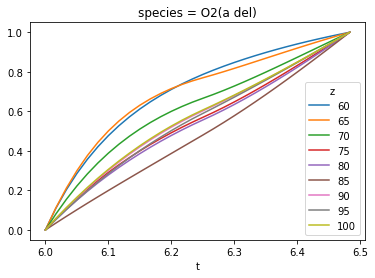

CPU times: user 49.4 s, sys: 11.1 ms, total: 49.4 s
Wall time: 49.4 s


In [22]:
# %%prun
%%time
o2del.remove_density()
o2sig.remove_density()
o1d.remove_density()

species_query = [o2del]
species_equilibrium = [o1d, o2sig]
x0 = np.ravel([np.zeros(z.shape)])
x = odeint(balance, x0, t, 
           args=(species_query, reaction_lst, species_equilibrium, 89.9))
x = x.reshape(len(t), len(species_query), len(z))

ratio = xr.DataArray(x/x[-1], (t*s2h, [s.name for s in species_query], z), ('t', 'species', 'z'))
ratio.sel(z=slice(60, 100)).isel(species=0).plot.line(x='t', add_legend=True)
# ratio.sel(z=slice(60, 100, 5)).isel(species=1).plot.line(x='t', add_legend=True)
# plt.gca().set(ylim=(0,2))
plt.show()

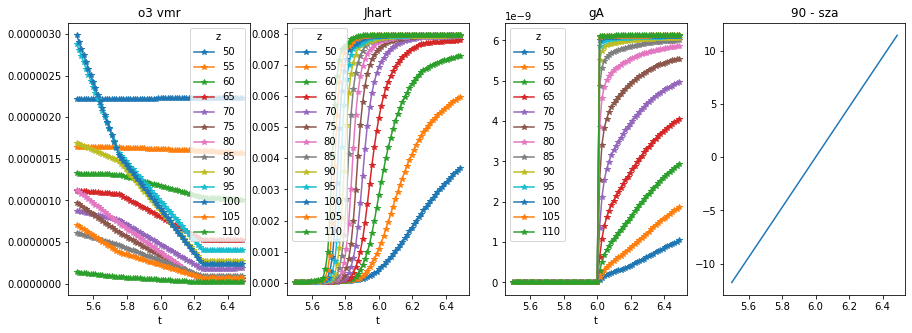

In [31]:
density = []
Jhart = []
g = []
for t_s in t:
    result = time_dependent_variables(t_s)
    density.append(result[0])
    Jhart.append(result[1])
    g.append(result[2])

set_dims = ((t*s2h, z), ('t', 'z'))
density = xr.DataArray(density, *set_dims)
Jhart = xr.DataArray(Jhart, *set_dims)
g = xr.DataArray(g, *set_dims)

alt_sel_args = dict()
line_plot_args = dict(x='t', marker='*', add_legend=True)
plt.figure(figsize=(15,5))
plt.subplot(141)
(density/m.density).sel(**alt_sel_args).plot.line(**line_plot_args)
plt.title('o3 vmr')
plt.subplot(142)
Jhart.sel(**alt_sel_args).plot.line(**line_plot_args)
plt.title('Jhart')
plt.subplot(143)
g.sel(**alt_sel_args).plot.line(**line_plot_args)
plt.title('gA')
plt.subplot(144)
plt.plot(t*s2h, 90-func_sza(t))
plt.title('90 - sza')
plt.show()

In [22]:
# def pend(y, t, b, c):
#     theta, omega = y
#     dydt = [omega, -b*omega - c*np.sin(theta)]
#     return dydt

# b = 0.25
# c = 5.0
# y0 = [np.pi - 0.1, 0.0]
# t = np.linspace(0, 10, 101)
# sol = odeint(pend, y0, t, args=(b, c))

In [23]:
# plt.plot(t, sol[:, 0], 'b', label='theta(t)')
# plt.plot(t, sol[:, 1], 'g', label='omega(t)')
# plt.legend(loc='best')
# plt.xlabel('t')
# plt.grid()
# plt.show()

In [24]:
# class BimolecReaction:
#     reaction_type = 'bimolecular reaction'
    
#     def __init__(self,  
#                  rate_constant=None, #rate_constant(),
#                  reactants=(), #(species(), species()),
#                  products=(),  
#                  name=None):
#         if isinstance(rate_constant, (RateConstant,) + NoneType):
#             self.rate_constant = rate_constant
# #         else:
# #             print('rate_constant must be a RateConstant')
        
#         if all(isinstance(i, Species) for i in reactants):
#             self.reactants = reactants
# #         else:
# #             print('all reactants must be Species')
            
#         if all(isinstance(i, Species) for i in products):
#             self.products = products
# #         else:
# #             print('all products must be Species')
        
#         if isinstance(name, (str,) + NoneType):
#             self.name = name
# #         else:
# #             print('name must be a string') 
        

#     def set_rate_constant(self, rate_constant):
#         if isinstance(rate_constant, RateConstant):
#             self.rate_constant = rate_constant
# #         else:
# #             print('rate_constant must be a RateConstant')
#         return self
#     def set_reactants(self, reactants):
#         if all(isinstance(i, Species) for i in reactants):
#             self.reactants = reactants
# #         else:
# #             print('all reactants must be species')
#         return self
#     def set_products(self, products):
#         if all(isinstance(i, Species) for i in products):
#             self.products = products
# #         else:
# #             print('all products must be species')
#         return self
#     def set_name(self, name):
#         if isinstance(name, str):
#             self.name = name
# #         else:
# #             print('name must be a string')
#         return self
    
#     def rate(self):
#         if all((all(isinstance(i, Species) for i in self.reactants),
#                 len(self.reactants)==2, 
#                 isinstance(self.rate_constant, RateConstant)
#                )):
#             return self.rate_constant.value * self.reactants[0].density * self.reactants[1].density
        

# class TrimolecReaction:
#     reaction_type = 'trimolecular'
    
#     def __init__(self,  
#                  rate_constant=None, #rate_constant(),
#                  reactants=(), #(species(), species(), species()),
#                  products=(),  
#                  name=None):
#         if isinstance(rate_constant, (RateConstant,) + NoneType):
#             self.rate_constant = rate_constant
# #         else:
# #             print('rate_constant must be a RateConstant')
        
#         if all(isinstance(i, Species) for i in reactants):
#             self.reactants = reactants
# #         else:
# #             print('all reactants must be Species')
            
#         if all(isinstance(i, Species) for i in products):
#             self.products = products
# #         else:
# #             print('all products must be Species')
        
#         if isinstance(name, (str,) + NoneType):
#             self.name = name
# #         else:
# #             print('name must be a string') 
        
#     def set_rate_constant(self, rate_constant):
#         if isinstance(rate_constant, RateConstant):
#             self.rate_constant = rate_constant
# #         else:
# #             print('rate_constant must be a RateConstant')
#         return self
#     def set_reactants(self, reactants):
#         if all(isinstance(i, Species) for i in reactants):
#             self.reactants = reactants
# #         else:
# #             print('all reactants must be species')
#         return self
#     def set_products(self, products):
#         if all(isinstance(i, Species) for i in products):
#             self.products = products
# #         else:
# #             print('all products must be species')
#         return self
#     def set_name(self, name):
#         if isinstance(name, str):
#             self.name = name
# #         else:
# #             print('name must be a string')
#         return self
    
#     def rate(self):
#         if all((all(isinstance(i, Species) for i in self.reactants),
#                 len(self.reactants)==3, 
#                 isinstance(self.rate_constant, RateConstant)
#                )):
#             return self.rate_constant.value * self.reactants[0].density * self.reactants[1].density * self.reactants[2].density

# class UnimolecReaction:
#     reaction_type = 'unimolecular'
    
#     def __init__(self,  
#                  rate_constant=None, #rate_constant(),
#                  reactants=(), #(species()),
#                  products=(),  
#                  name=None):
#         if isinstance(rate_constant, (RateConstant,) + NoneType):
#             self.rate_constant = rate_constant
# #         else:
# #             print('rate_constant must be a RateConstant')
        
#         if all(isinstance(i, Species) for i in reactants):
#             self.reactants = reactants
# #         else:
# #             print('all reactants must be Species')
            
#         if all(isinstance(i, Species) for i in products):
#             self.products = products
# #         else:
# #             print('all products must be Species')
        
#         if isinstance(name, (str,) + NoneType):
#             self.name = name
# #         else:
# #             print('name must be a string') 
        
#     def set_rate_constant(self, rate_constant):
#         if isinstance(rate_constant, RateConstant):
#             self.rate_constant = rate_constant
# #         else:
# #             print('rate_constant must be a RateConstant')
#         return self
#     def set_reactants(self, reactants):
#         if all(isinstance(i, Species) for i in reactants):
#             self.reactants = reactants
# #         else:
# #             print('all reactants must be species')
#         return self
#     def set_products(self, products):
#         if all(isinstance(i, Species) for i in products):
#             self.products = products
# #         else:
# #             print('all products must be species')
#         return self
#     def set_name(self, name):
#         if isinstance(name, str):
#             self.name = name
# #         else:
# #             print('name must be a string')
#         return self
    
#     def rate(self):
#         if all((all(isinstance(i, Species) for i in self.reactants),
#                 len(self.reactants)==1, 
#                 isinstance(self.rate_constant, RateConstant)
#                )):
#             return self.rate_constant.value * self.reactants[0].density 

# just some tests to make sure there is no error message

In [25]:
#test an ampty instance of reaction
# r0 = BimolecReaction()

In [26]:
#test a reaction with arrays of densities 
# o2 = Species(density=np.arange(10), unit='cm-3')
# n2 = Species(density=np.ones(10), unit='cm-3')
# T = np.arange(10)
# k = RateConstant(value=111*T, unit='cm3s-1')
# r1 = BimolecReaction(rate_constant=k, products=(o2, n2))
# r1.set_reactants((o2,o2))
# r1.rate()

In [27]:
#test a reaction with density element number of one 
# o2 = Species(density=9, unit='cm-3')
# n2 = Species(density=1, unit='cm-3')
# T = 9
# k = RateConstant(value=111*T, unit='cm3s-1')
# r2 = BimolecReaction(rate_constant=k, products=(o2, n2))
# r2.set_reactants((o2,o2))
# r2.rate()